In [1]:
import pandas as pd
import numpy as np

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv('updated_train.csv')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,h_distance,day,month,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.498521,1.497580,14,3,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.805507,1.804374,12,6,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.385098,6.381090,19,1,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.485498,1.484566,6,4,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.188588,1.187842,26,3,13,30


In [4]:
test = pd.read_csv('updated_test.csv')
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,h_distance,day,month,hour,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2.746426,2.744701,30,6,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2.759239,2.757507,30,6,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,1.306155,1.305335,30,6,23,59
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,5.269088,5.265780,30,6,23,59
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,0.960842,0.960239,30,6,23,59


In [5]:
train['pickup_time'] = train['hour'] + (train['minute']/60)
test['pickup_time'] = test['hour'] + (test['minute']/60)

In [7]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'h_distance', 'day', 'month', 'hour',
       'minute', 'pickup_time'],
      dtype='object')

In [15]:
train['trip_duration'] = np.log(train['trip_duration']+1)

In [6]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost.sklearn import XGBRegressor

In [8]:
features = ['vendor_id', 'passenger_count','store_and_fwd_flag','day', 'month', 'hour', 'minute','h_distance','pickup_time']

In [26]:
xgb = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=10,
                   min_child_weight=3, gamma=0.005, colsample_bylevel=1.0 , colsample_bytree=0.9,reg_lambda=4,
                   objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27,subsample=0.8,reg_alpha=0.01)

In [27]:
xgb.fit(train[features],train['trip_duration'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.9, gamma=0.005, learning_rate=0.01,
       max_delta_step=0, max_depth=10, min_child_weight=3, missing=None,
       n_estimators=1000, nthread=4, objective='reg:linear',
       reg_alpha=0.01, reg_lambda=4, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)

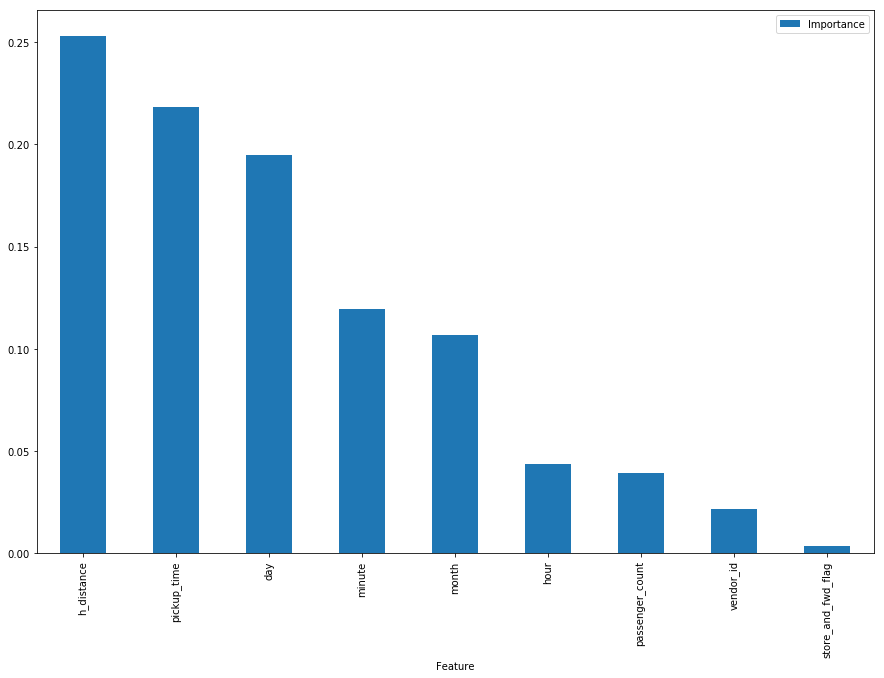

In [28]:
feature_importance = pd.Series(xgb.feature_importances_)
feature_ser = pd.Series(features)
lis = pd.Series(feature_importance.values,index = feature_ser)
lis = sorted(lis.items(),key =lambda x:(-x[1],x[0]))
df = pd.DataFrame(lis, columns=['Feature', 'Importance'])
df.plot(kind='bar',x='Feature',figsize=(15,10))

In [29]:
pred = xgb.predict(test[features])
print('prediction is done')

prediction is done


In [30]:
def update(x):
    if(x<0):
        return -x
    return x

In [31]:
pred = np.exp(pred)-1

In [32]:
sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = pred
sub['trip_duration'] = sub['trip_duration'].apply(lambda x:update(x))
sub.to_csv('xgb.csv', index=False)
print('writting is done.')

writting is done.
